In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

# 1. Data Structure and Exploratory Analysis


In [2]:
# Read the Excel file into a pandas DataFrame
file_path = "Connect_analyst_priklad.xlsx"
df = pd.read_excel(file_path)

# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ACCOUNTING_MONTH_KEY  384 non-null    int64  
 1   tribe                 384 non-null    object 
 2   Area                  384 non-null    object 
 3   Revenue               384 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.1+ KB
None


In [3]:
# Show the first five rows of the dataset to understand its structure
print(df.head())

   ACCOUNTING_MONTH_KEY         tribe            Area      Revenue
0                202101         Store     Fixed Voice   206316.080
1                202101       Protect              IT  2628488.080
2                202101  Industry 4.0              IT  2773775.168
3                202101       Connect              IT  3357278.610
4                202101       Connect  Fixed Internet  6852624.889


In [4]:
# Check for empty cells in the DataFrame
missing_values = df.isnull().sum()
print(missing_values)

ACCOUNTING_MONTH_KEY    0
tribe                   0
Area                    0
Revenue                 0
dtype: int64


The dataset contains 384 rows, 4 columns and 0 missing values:

- **ACCOUNTING_MONTH_KEY** – Year and month in the format YYYYMM (e.g., 202101 = January 2021).
- **tribe** – Product category.
- **Area** – Specific product area.
- **Revenue** – Invoice amount (revenue) for the given month.


- The data covers multiple product areas (**Area**) and product categories (**tribe**).
- Revenue (**Revenue**) is represented as a decimal number.
- **ACCOUNTING_MONTH_KEY** needs to be converted to the datetime data type for better time series analysis.


# 2. Trends in the Total Revenue Development

In [5]:
# Convert ACCOUNTING_MONTH_KEY to datetime
df['Date'] = pd.to_datetime(df['ACCOUNTING_MONTH_KEY'].astype(str), format='%Y%m')

# Sort by Date
df = df.sort_values(by='Date')

# Aggregate Total Revenue for Each Month
df_monthly = df.groupby('Date')['Revenue'].sum().reset_index()

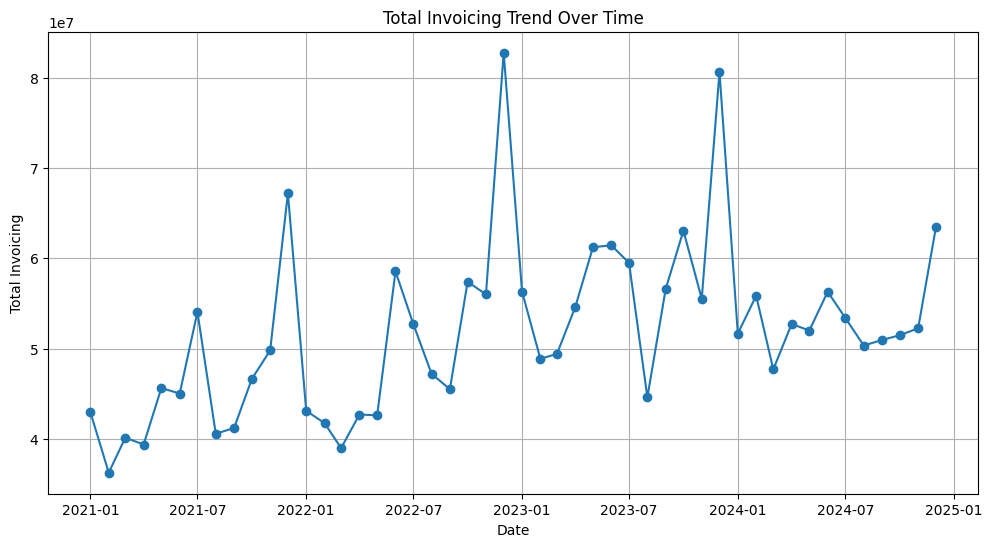

In [6]:
# Plot the Time Series of Total Revenue
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Date'], df_monthly['Revenue'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Invoicing')
plt.title('Total Invoicing Trend Over Time')
plt.grid(True)
plt.show()


The chart reveals the following trends in total revenue:

- **Fluctuations over time** – Revenue varies from month to month, but there are no extreme swings.
- **Slight upward trend** – Total revenue appears to be gradually increasing over the long term.
- **Seasonal variations** – Regular patterns are noticeable, which may indicate seasonality.

# 3. Analysis of Revenue Trend by Tribe Over Time

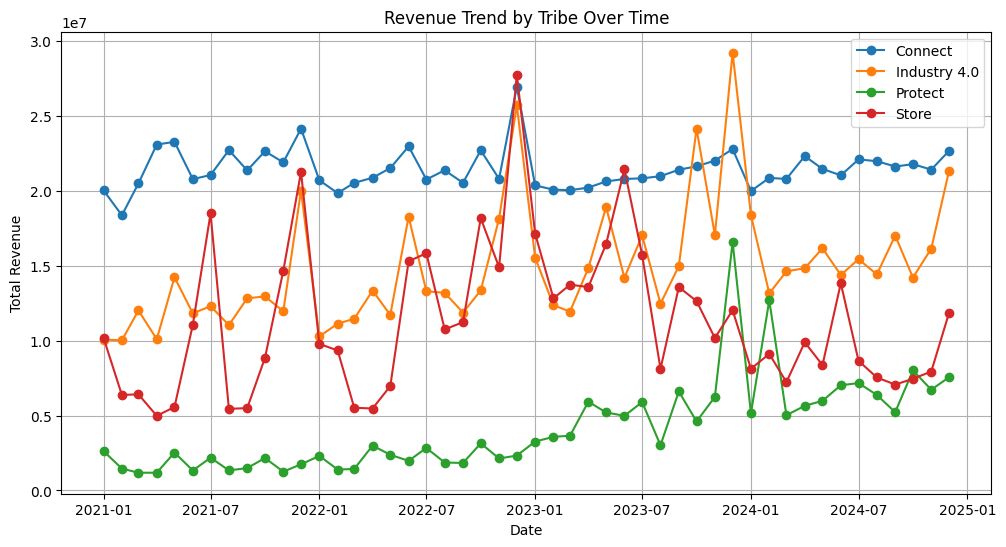

In [7]:
# Sort by Date
df = df.sort_values(by='Date')

# Aggregate Revenue by Tribe and Date
df_tribe = df.groupby(['Date', 'tribe'])['Revenue'].sum().reset_index()

# Aggregate Revenue by Area and Date
df_area = df.groupby(['Date', 'Area'])['Revenue'].sum().reset_index()

# Plot the Time Series of Revenue by Tribe
plt.figure(figsize=(12, 6))
for tribe in df_tribe['tribe'].unique():
    subset = df_tribe[df_tribe['tribe'] == tribe]
    plt.plot(subset['Date'], subset['Revenue'], marker='o', linestyle='-', label=tribe)

plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Revenue Trend by Tribe Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Key Observations
- **Connect** (Blue Line) shows a relatively stable upward trend with minor fluctuations, indicating steady growth over time.
- **Industry 4.0** (Orange Line) exhibits noticeable seasonality, with regular peaks and troughs, suggesting periodic variations in revenue.
- **Protect** (Green Line) remains at a lower revenue level but shows an increasing trend with occasional spikes.
- **Store** (Red Line) demonstrates high volatility with sharp fluctuations, suggesting an irregular revenue pattern, possibly influenced by external factors.

## Insights
- There is a clear seasonal effect in some tribes, particularly **Industry 4.0** and **Store**, which have significant periodic variations.
- **Connect** maintains the highest and most stable revenue stream among the tribes.
- Sudden peaks, especially in **Store** and **Industry 4.0**, might be driven by specific market conditions or promotional activities.
- The **Protect** tribe shows gradual improvement, indicating potential growth opportunities.


# 4. Analysis of Revenue Trend by Area Over Time

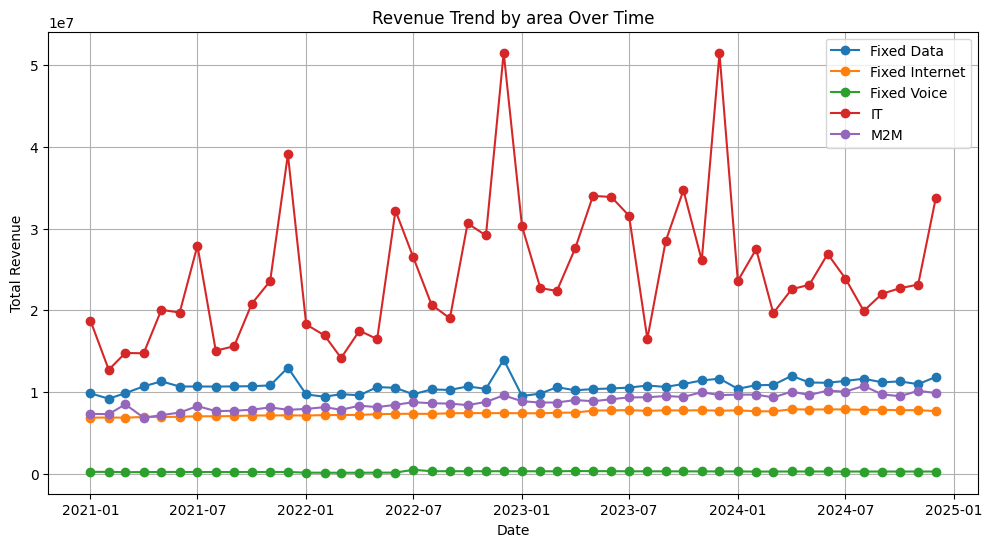

In [8]:
# Plot the Time Series of Revenue by Area
plt.figure(figsize=(12, 6))
for area in df_area['Area'].unique():
    subset = df_area[df_area['Area'] == area]
    plt.plot(subset['Date'], subset['Revenue'], marker='o', linestyle='-', label=area)

plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Revenue Trend by area Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Key Observations
- **IT (Red Line)** exhibits high volatility with frequent peaks and drops, indicating significant fluctuations in revenue. The spikes suggest seasonal or event-driven impacts.
- **Fixed Data (Blue Line)** and **M2M (Purple Line)** show a stable, slightly increasing trend over time, with minor fluctuations.
- **Fixed Internet (Orange Line)** and **Fixed Voice (Green Line)** remain relatively stable, showing limited growth and low volatility.

## Insights
- **IT** dominates in terms of revenue but shows unpredictable patterns, suggesting external factors heavily influence revenue generation.
- **Fixed Data** and **M2M** appear to be more predictable, possibly due to stable customer contracts or recurring revenue streams.
- **Fixed Internet** and **Fixed Voice** maintain consistent levels, indicating steady but low-growth business areas.
- Seasonal peaks in **IT** may be linked to major infrastructure projects, technological upgrades, or shifts in demand.

# 5. Time Series Decomposition Analysis

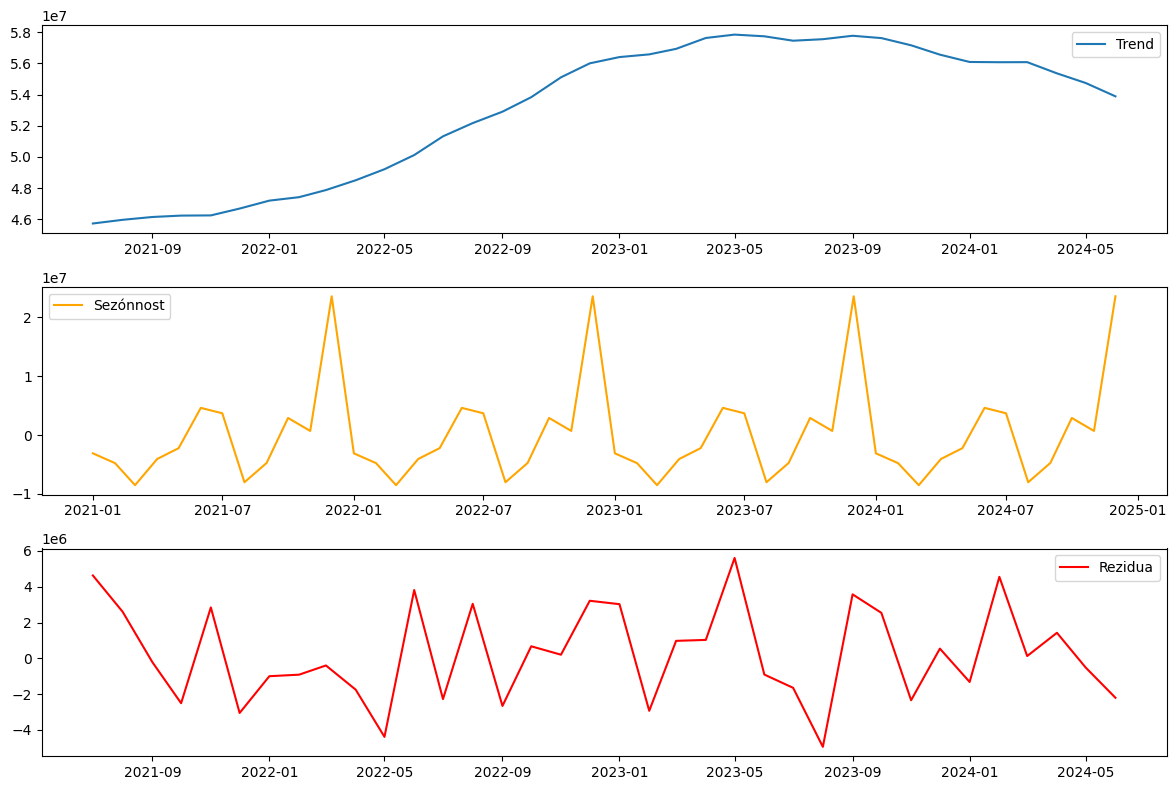

In [9]:
# TimeSeries decomposition
decomposition = seasonal_decompose(df_monthly.set_index('Date')['Revenue'], model='additive', period=12)

# PLot the TimeSeries
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Sezónnost', color='orange')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Rezidua', color='red')
plt.legend()

plt.tight_layout()
plt.show()

## Key Observations
- **Trend (Top Chart, Blue Line)**:
  - The overall trend indicates a **steady increase** in revenue from early 2021 to mid-2023.
  - Growth slows slightly after mid-2023, followed by a **minor decline** towards 2024.
  - This suggests a period of expansion followed by stabilization or slight contraction.

- **Seasonality (Middle Chart, Orange Line)**:
  - The pattern reveals **strong seasonal effects**, with recurring peaks and troughs.
  - Peaks seem to occur at **regular intervals**, indicating predictable revenue cycles.
  - The seasonal influence is relatively large compared to the total revenue, implying high dependency on seasonal trends.

- **Residuals (Bottom Chart, Red Line)**:
  - The residual component shows **irregular fluctuations**, but no significant anomalies.
  - The variations suggest that the **trend and seasonality explain most of the revenue movements**, leaving only minor unpredictable deviations.
  - Some spikes in residuals indicate occasional unexpected revenue shifts, possibly due to external events or market disruptions.

## Insights
- The **long-term growth trend** suggests a generally positive performance, though a slight decline in 2024 warrants further investigation.
- **Seasonality plays a crucial role**, and future planning should account for these fluctuations to optimize revenue management.
- The **residual component is relatively small**, indicating that the model effectively captures the underlying trend and seasonal effects.


# 6. XGBoost-Based Time Series Forecasting with Bootstrapped Confidence Intervals

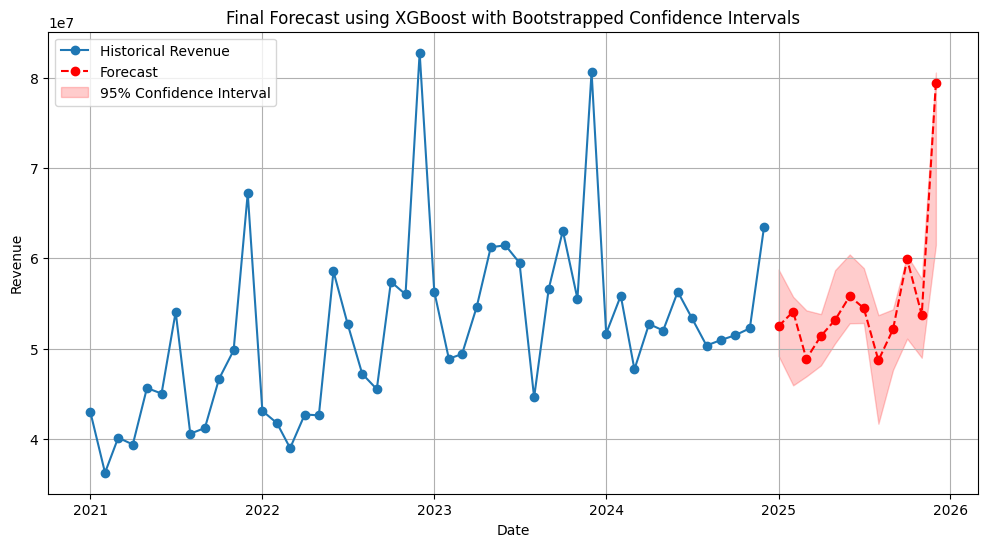

In [10]:
# Load data
file_path = "Connect_analyst_priklad.xlsx"
df = pd.read_excel(file_path)

# Convert ACCOUNTING_MONTH_KEY to datetime and aggregate revenue per month
df["Date"] = pd.to_datetime(df["ACCOUNTING_MONTH_KEY"].astype(str), format="%Y%m")
df_monthly = df.groupby("Date")["Revenue"].sum().reset_index()

# Create time-based features
df_monthly["Year"] = df_monthly["Date"].dt.year
df_monthly["Month"] = df_monthly["Date"].dt.month
df_monthly["Year_squared"] = df_monthly["Year"] ** 2

# Define features and target
X = df_monthly[["Year", "Month", "Year_squared"]]
y = df_monthly["Revenue"]

# --- Rolling Forecast Split ---
def rolling_forecast_split(X, y, initial=12, step=3):
    """Expanding window time-series split"""
    for i in range(initial, len(X), step):
        X_train, X_test = X.iloc[:i], X.iloc[i:i+step]
        y_train, y_test = y.iloc[:i], y.iloc[i:i+step]
        yield X_train, X_test, y_train, y_test

# --- Hyperparameter Tuning for XGBoost ---
xgb_param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.01, 0.05],
    "max_depth": [3, 5]
}

xgb_grid_search = GridSearchCV(XGBRegressor(objective="reg:squarederror", random_state=42), xgb_param_grid, cv=3, scoring="neg_mean_absolute_error")
xgb_grid_search.fit(X, y)
best_model = xgb_grid_search.best_estimator_

# --- Model Evaluation ---
mae_list, rmse_list, residuals_list = [], [], []
for X_train, X_test, y_train, y_test in rolling_forecast_split(X, y, initial=12, step=3):
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    residuals = y_test - y_pred
    residuals_list.extend(residuals)
    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Compute additional error metrics
mape_list = [np.mean(np.abs((y_test - best_model.predict(X_test)) / y_test)) * 100 
             for X_train, X_test, y_train, y_test in rolling_forecast_split(X, y, initial=12, step=3)]

mpe_list = [np.mean((y_test - best_model.predict(X_test)) / y_test) * 100 
            for X_train, X_test, y_train, y_test in rolling_forecast_split(X, y, initial=12, step=3)]

r2_list = [r2_score(y_test, best_model.predict(X_test)) 
           for X_train, X_test, y_train, y_test in rolling_forecast_split(X, y, initial=12, step=3)]

# Aggregate results
error_metrics = {
    "Mean Absolute Percentage Error (MAPE)": np.mean(mape_list),
    "Mean Percentage Error (MPE)": np.mean(mpe_list),
    "R-squared (R²)": np.mean(r2_list)
}

# --- Forecasting Next 12 Months ---
future_dates = pd.date_range(start=df_monthly["Date"].max() + pd.DateOffset(months=1), periods=12, freq="MS")
future_X = pd.DataFrame({"Year": future_dates.year, "Month": future_dates.month, "Year_squared": future_dates.year ** 2})

# Predict future revenue
future_predictions = best_model.predict(future_X)

# --- Bootstrapped Confidence Intervals ---
bootstrap_samples = 1000
bootstrap_preds = []
for _ in range(bootstrap_samples):
    sample_idx = np.random.choice(len(y), size=len(y), replace=True)
    sample_X, sample_y = X.iloc[sample_idx], y.iloc[sample_idx]
    
    best_model.fit(sample_X, sample_y)
    sample_pred = best_model.predict(future_X)
    
    bootstrap_preds.append(sample_pred)

bootstrap_preds = np.array(bootstrap_preds)
lower_bound = np.percentile(bootstrap_preds, 2.5, axis=0)  
upper_bound = np.percentile(bootstrap_preds, 97.5, axis=0)

# --- Forecast Visualization ---
future_forecast = pd.DataFrame({
    "Date": future_dates,
    "Predicted Revenue": future_predictions,
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound
})

# Plot prediciton
plt.figure(figsize=(12, 6))
plt.plot(df_monthly["Date"], df_monthly["Revenue"], marker="o", linestyle="-", label="Historical Revenue")
plt.plot(future_forecast["Date"], future_forecast["Predicted Revenue"], marker="o", linestyle="--", color="red", label="Forecast")
plt.fill_between(future_forecast["Date"], future_forecast["Lower Bound"], future_forecast["Upper Bound"], color="red", alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Final Forecast using XGBoost with Bootstrapped Confidence Intervals")
plt.legend()
plt.grid()
plt.show()


## **Key Observations**
- **Historical Revenue (Blue Line)**
  - Shows significant **seasonal fluctuations** with **sharp peaks and troughs**.
  - A general upward trend is observed over time, despite **high variability** in certain periods.
  - Revenue spikes periodically, indicating potential external influences (e.g., promotions, market trends).

- **Forecasted Revenue (Red Dotted Line)**
  - The model predicts **moderate growth** with continued **seasonal effects**.
  - Short-term predictions align closely with historical trends.
  - The forecasted values indicate **some uncertainty** as time progresses.

- **95% Confidence Interval (Red Shaded Area)**
  - Represents the **range of possible revenue values** based on bootstrapped simulations.
  - Initially, confidence bounds are **narrow**, indicating **high confidence** in short-term predictions.
  - The range **widens towards 2026**, highlighting increasing uncertainty in long-term forecasts.
  - A **potential high growth scenario** is indicated towards the end of the forecast period.

## **Insights**
**High variability in historical data** suggests strong seasonal trends, which the model captures well.  
**Bootstrapped confidence intervals** provide a realistic uncertainty measure, with wider bands in longer forecasts.  
The **forecast suggests continued growth**, with potential **significant revenue spikes** towards the end of the period.  
Uncertainty increases over time, indicating the need for **regular model updates** as new data becomes available.  

# 7. Performance Analysis

In [11]:
# Print performance metrics
print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {np.mean(mae_list):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.mean(rmse_list):,.2f}")


Model Performance:
Mean Absolute Error (MAE): 5,625,723.68
Root Mean Squared Error (RMSE): 6,454,584.34


In [12]:
# Display error metrics
error_metrics_df = pd.DataFrame([error_metrics])
display(error_metrics_df)

,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),R-squared (R²)
0,3.599369,-1.405512,0.442614


## **Key Observations**

The **MAE** is **5,625,723.68**, meaning that, on average, the model's predictions deviate from the actual values by about **5.63 million** in absolute terms.  
This metric provides a straightforward interpretation of **prediction error** but does **not penalize larger errors more than smaller ones**.  

The **RMSE** is **6,454,584.34**, indicating that the **typical prediction error** is around **6.45 million**.  
**RMSE penalizes larger errors more than smaller ones** due to squaring before averaging, making it **more sensitive to outliers**.  


**MAPE of 3.60%** suggests that the model is relatively **accurate**, with low percentage errors.  

**MPE close to zero (-1.41%)** indicates **minimal bias**, though there is a slight underestimation.  

**R² of 0.44** suggests that while the model captures some trends, **more predictive factors or feature engineering** might improve its performance.  

# 8. Forecast

In [13]:
# Display forecast in tabular format
future_forecast_formatted = future_forecast.copy()
future_forecast_formatted["Predicted Revenue"] = future_forecast_formatted["Predicted Revenue"].apply(lambda x: f"{x:,.0f}")
future_forecast_formatted["Lower Bound"] = future_forecast_formatted["Lower Bound"].apply(lambda x: f"{x:,.0f}")
future_forecast_formatted["Upper Bound"] = future_forecast_formatted["Upper Bound"].apply(lambda x: f"{x:,.0f}")
display(future_forecast_formatted)

,Date,Predicted Revenue,Lower Bound,Upper Bound
0,2025-01-01,"52,478,960","49,187,287","58,761,682"
1,2025-02-01,"54,091,896","45,924,763","55,725,507"
2,2025-03-01,"48,854,660","46,911,368","54,231,428"
3,2025-04-01,"51,397,932","48,134,392","53,817,903"
4,2025-05-01,"53,166,516","50,576,548","58,686,621"
5,2025-06-01,"55,795,504","52,799,087","60,420,429"
6,2025-07-01,"54,475,004","52,830,121","58,906,061"
7,2025-08-01,"48,685,400","41,671,093","53,696,085"
8,2025-09-01,"52,129,868","47,634,700","54,346,126"
9,2025-10-01,"59,892,276","51,098,310","60,287,906"


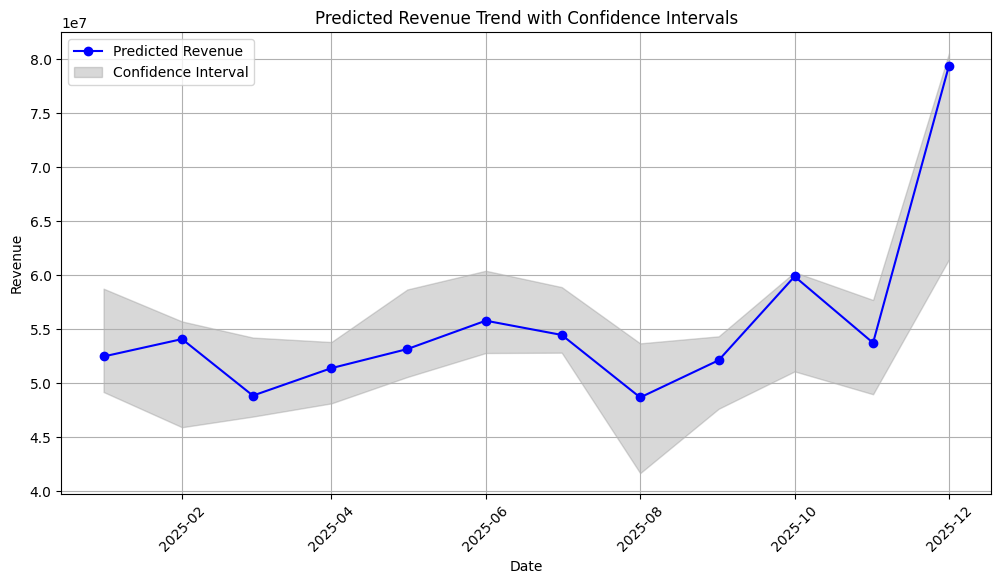

In [14]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(future_forecast["Date"], future_forecast["Predicted Revenue"], marker="o", label="Predicted Revenue", color='blue')
plt.fill_between(future_forecast["Date"], future_forecast["Lower Bound"], future_forecast["Upper Bound"], color='gray', alpha=0.3, label="Confidence Interval")

# Formatting date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Predicted Revenue Trend with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

## **Key Observations**
**Steady Revenue Growth:**  
   - Predicted revenue generally increases over the months, peaking in December 2025.

**Seasonal Volatility:**  
   - **August 2025** shows a dip (**48.69M**), aligning with historical seasonal declines.
   - **December 2025** experiences a **sharp spike to 79.43M**, potentially indicating a strong end-of-year trend.

**Uncertainty Trends:**  
   - The **95% confidence intervals** widen in **December**, suggesting **higher uncertainty** in long-term predictions.
   - The **August forecast has a larger uncertainty range**, implying potential variability.

## **Insights & Recommendations**
🔹 **Plan for High Revenue Spikes**  
   - The **December 2025 surge** suggests a significant revenue peak.  
   - Businesses should align **marketing, staffing, and inventory strategies** accordingly.

🔹 **Address the August Dip**  
   - **August historically shows a decline**—possible causes: seasonality, market slowdowns.  
   - Implement **revenue-boosting strategies** such as promotions or special offers in this period.

🔹 **Monitor Forecast Accuracy Over Time**  
   - Since long-term predictions show **higher uncertainty**, periodic **recalibration of the model** with updated data is necessary.